# CLASH OF NEIGHBOURHOOD

## IBM DATA SCIENCE CAPSTONE PROJECT

### WEEK 5 FINAL CODE

# OPENING DEPARTMENT STORE IN OPTIMISED PLACES OF BANGALORE, INDIA

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import geocoder #to convert address into latitude and longitude
import requests
from bs4 import BeautifulSoup #for webscrapping
import folium #for visualizing maps
import json #for reading jason files returned by the FourSquare API
from sklearn.cluster import KMeans #for clustering areas
import matplotlib.cm as cm #for colouring clusters with different colours
import matplotlib.colors as color
import matplotlib.pyplot as plt; #to plot graphs
from scipy.spatial.distance import cdist #for performing elbow method to choose correct value of k

## 2. Scrapping data from wikipedia using BeautifulSoup

In [2]:
data=requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore").text
soup=BeautifulSoup(data,'html.parser')
neighborhood=[]
for table in soup.find_all('table'):
    for row in table.find_all('tr'):
        cells=row.find_all('td')
        if(len(cells)>0):
            neighborhood.append(cells[0].text.rstrip("\n"))
df_neighborhood=pd.DataFrame({"Neighborhood":neighborhood})
df_neighborhood.drop([65,66,67,68,69,70,71],inplace=True)
print(df_neighborhood.shape)
df_neighborhood.tail(10)

(65, 1)


,Neighborhood
55,Basaveshwaranagar
56,Kamakshipalya
57,Kengeri
58,Mahalakshmi Layout
59,Nagarbhavi
60,Nandini Layout
61,Nayandahalli
62,Rajajinagar
63,Rajarajeshwari Nagar
64,Vijayanagar


## 3. Getting geographical coordinates using Geocoder

In [3]:
cords=[]
for n in df_neighborhood["Neighborhood"]:
    g=geocoder.arcgis('{}, Bangalore, India'.format(n))
    ll=g.latlng
    cords.append(ll)
cords

[[28.651000000000067, 77.17535000000004],
 [12.943290000000047, 77.65602000000007],
 [13.030060000000049, 77.49526000000003],
 [12.96601000000004, 77.65767000000005],
 [13.006319846827683, 77.5684048532483],
 [12.966180000000065, 77.58690000000007],
 [13.014830000000075, 77.57771000000008],
 [12.993550000000027, 77.57988000000006],
 [12.98720000000003, 77.60401000000007],
 [12.989080000000058, 77.62795000000006],
 [12.990730000000042, 77.58861000000007],
 [12.927340000000072, 77.67169000000007],
 [12.979001728079757, 77.65613222110436],
 [12.99198000000007, 77.71506000000005],
 [13.000390000000039, 77.68368000000004],
 [12.994090000000028, 77.66633000000007],
 [12.954660000000047, 77.70752000000005],
 [12.943480000000022, 77.74703000000005],
 [12.975230000000067, 77.75238000000007],
 [13.019526632499165, 77.65502770568062],
 [13.02642000000003, 77.62437000000006],
 [13.038700000000063, 77.66192000000007],
 [12.968020000000024, 77.52114000000006],
 [13.014300000000048, 77.63685000000004

In [4]:
#convert cords into dataframe and concat with df_neiborhood

df_cords = pd.DataFrame(cords, columns=['Latitude','Longitude'])
df_neighborhood['Latitude'] = df_cords['Latitude']
df_neighborhood['Longitude'] = df_cords['Longitude']
print(df_neighborhood.shape)
df_neighborhood.tail(10)

(65, 3)


,Neighborhood,Latitude,Longitude
55,Basaveshwaranagar,12.98674,77.54389
56,Kamakshipalya,12.98699,77.52484
57,Kengeri,12.90870,77.48714
58,Mahalakshmi Layout,13.01635,77.54481
59,Nagarbhavi,12.95624,77.50936
60,Nandini Layout,13.01481,77.53891
61,Nayandahalli,12.94205,77.52100
62,Rajajinagar,13.00544,77.55693
63,Rajarajeshwari Nagar,12.93178,77.52668
64,Vijayanagar,13.07600,77.65238


## 4. Visualizing the neiborhoods

In [5]:
#accessing latitude and longitude values of Bangalore

name="Bangalore, India"
geoloc = Nominatim(user_agent="my_application")
loc = geoloc.geocode(name)
lat = loc.latitude
lon = loc.longitude
print("Bangalore, India {} {} ".format(lat,lon)) #will be required to generate map of Bangalore

Bangalore, India 12.9791198 77.5912997 


In [6]:
#creating map using folium

map_neighborhood = folium.Map(location=[lat,lon], zoom_start=10)
for lt,lg,n in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(n)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lt,lg], radius=5, popup=label, color='blue', fill=True, fill_color='red', fill_opacity=0.7).add_to(map_neighborhood)
map_neighborhood

## 5. Using FourSquare API to explore these neighborhoods

In [7]:
#my credentials
id="PT0LDSCGFFXT4HWLLN2UJB3M4GBMGOAJHWSQRTEE4G2SAA3E"
secret="Z1HE1SXNLPP4KOKYTTLW3DOUGCS3SNEDKCXMDJQDBDUDJBKP"
version="20180605"

radius=1000 #within 1000m radiun
limit=100 #100 venues
venues=[]
for lt,lg,n in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'],df_neighborhood['Neighborhood']):
    url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(id,secret,version,lt,lg,radius,limit)
    results=requests.get(url).json()["response"]["groups"][0]["items"]
    for venue in results:
        venues.append((n,lt,lg,venue['venue']['name'],venue['venue']['location']['lat'],venue['venue']['location']['lng'],venue['venue']['categories'][0]['name']))

#venues list into dataframe

df_venues=pd.DataFrame(venues)
df_venues.columns=['Neighborhood','Latitude','Longitude','VenueName','VenueLat', 'VenueLong', 'VenueCategory']
print(df_venues.shape)
df_venues.head(10)

(1566, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLat,VenueLong,VenueCategory
0,Cantonment area,28.651,77.17535,Lantern's,28.643183,77.177746,Bar
1,Cantonment area,28.651,77.17535,Dunkin',28.645402,77.172580,Donut Shop
2,Cantonment area,28.651,77.17535,Jaypee Siddharth,28.642483,77.175543,Hotel
3,Cantonment area,28.651,77.17535,Barista,28.645457,77.173248,Coffee Shop
4,Cantonment area,28.651,77.17535,Barista,28.648718,77.176395,Arcade
5,Cantonment area,28.651,77.17535,Cafe Coffee Day,28.645622,77.172255,Café
6,Cantonment area,28.651,77.17535,Domino's Pizza,28.644000,77.174000,Pizza Place
7,Cantonment area,28.651,77.17535,Domino's Pizza,28.645000,77.169000,Pizza Place
8,Cantonment area,28.651,77.17535,Imly,28.644607,77.178591,Fast Food Restaurant
9,Cantonment area,28.651,77.17535,McDonald's,28.642594,77.177378,Fast Food Restaurant


In [8]:
df_copy=df_venues.groupby(["Neighborhood"]).count()
df_copy

,Latitude,Longitude,VenueName,VenueLat,VenueLong,VenueCategory
Neighborhood,,,,,,
Anjanapura,1,1,1,1,1,1
Arekere,40,40,40,40,40,40
BTM Layout,48,48,48,48,48,48
Banashankari,47,47,47,47,47,47
Banaswadi,11,11,11,11,11,11
...,...,...,...,...,...,...
Vidyaranyapura,6,6,6,6,6,6
Vijayanagar,4,4,4,4,4,4
Whitefield,18,18,18,18,18,18


In [9]:
df_plot=df_copy.drop(["Latitude","Longitude","VenueName","VenueLat","VenueLong"],1)
df_plot

,VenueCategory
Neighborhood,
Anjanapura,1
Arekere,40
BTM Layout,48
Banashankari,47
Banaswadi,11
...,...
Vidyaranyapura,6
Vijayanagar,4
Whitefield,18


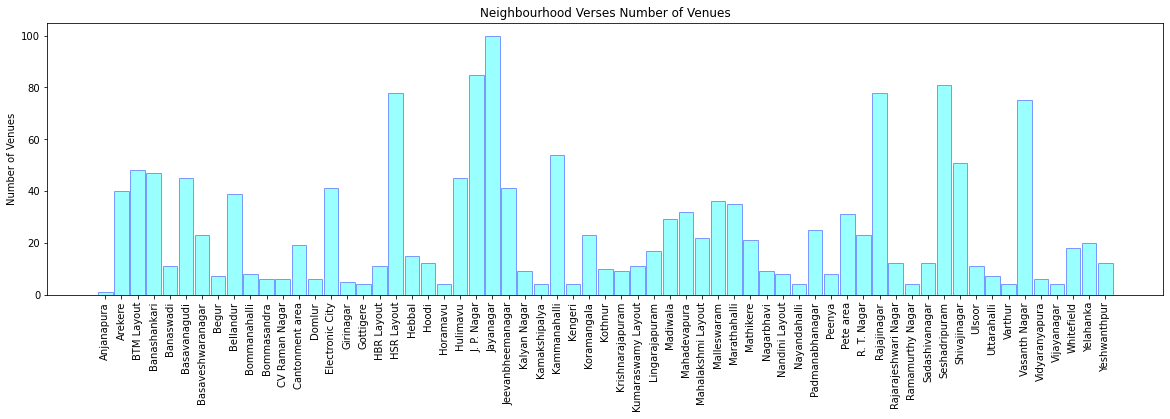

In [22]:
#ploting a bar chart

n=df_plot.index
y=np.arange(len(n))
count=df_plot.VenueCategory
plt.bar(y,count,width=0.9,color='cyan', edgecolor='blue',align="center",alpha=0.4)
plt.xticks(y,n)
plt.ylabel("Number of Venues")
#plt.xlable("Number of Venue Category")
plt.title("Neighbourhood Verses Number of Venues")
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=(20,5)
plt.show()

In [26]:
#not much venues are available in my city
#lets see the unique categories

df_venues['VenueCategory'].unique()

array(['Bar', 'Donut Shop', 'Hotel', 'Coffee Shop', 'Arcade', 'Café',
       'Pizza Place', 'Fast Food Restaurant',
       'Multicuisine Indian Restaurant', 'Park', 'Metro Station',
       'Breakfast Spot', 'Electronics Store', 'Light Rail Station',
       'Gym / Fitness Center', 'Bakery', 'Restaurant', 'Pharmacy',
       'Golf Course', 'Indian Restaurant', 'Chinese Restaurant',
       'Korean Restaurant', 'Juice Bar', 'Food Truck', 'Smoke Shop',
       'Dessert Shop', 'Department Store', 'Middle Eastern Restaurant',
       'Bus Station', 'Gym', 'Karnataka Restaurant',
       'South Indian Restaurant', 'Snack Place', 'Ice Cream Shop',
       'Vegetarian / Vegan Restaurant', 'Flea Market',
       'Performing Arts Venue', 'American Restaurant', "Women's Store",
       'Boat or Ferry', 'Theater', 'Fried Chicken Joint', 'Bagel Shop',
       'Track Stadium', 'Stadium', 'Miscellaneous Shop',
       'Seafood Restaurant', 'Plaza', 'Liquor Store', 'Art Gallery',
       'Pub', 'Food & Drink Shop

In [27]:
"Department Store" in df_venues['VenueCategory'].unique()

True

## 6. Analysing Neighborhoods using OneHot Encoding

In [28]:
df_onehot = pd.get_dummies(df_venues[['VenueCategory']],prefix="",prefix_sep="")
df_onehot['Neighborhood']=df_venues['Neighborhood']
columns=list(df_onehot.columns[:])
df_onehot=df_onehot[columns]
print(df_onehot.shape)
df_onehot.head()

(1566, 180)


,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Toll Booth,Track Stadium,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_onehotgrouped = df_onehot.groupby(["Neighborhood"]).mean().reset_index()
print(df_onehotgrouped.shape)
df_onehotgrouped.head(20)

(63, 180)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,...,Toll Booth,Track Stadium,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store
0,Anjanapura,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,Arekere,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,BTM Layout,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020833,...,0.0,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000
3,Banashankari,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.021277,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,Banaswadi,0.0,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000
5,Basavanagudi,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.022222,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
6,Basaveshwaranagar,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.086957,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
7,Begur,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
8,Bellandur,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
9,Bommanahalli,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [30]:
top=10;
indicators=['st','nd','rd']
area=['Neighborhood']
freq=[]
for i in np.arange(top):
    try:
        freq.append('{}{} Most Common Venue'.format(i+1,indicators[i]))
    except:
        freq.append('{}th Most Common Venue'.format(i+1))
columns=area+freq
df_topvenues=pd.DataFrame(columns=columns)
df_topvenues['Neighborhood']=df_onehotgrouped['Neighborhood']
for i in np.arange(df_onehotgrouped.shape[0]):
    row=df_onehotgrouped.iloc[i,:].iloc[1:]
    row_sorted=row.sort_values(ascending=False)
    df_topvenues.iloc[i,1:]=row_sorted.index.values[0:top]
print(df_topvenues.shape)
df_topvenues.tail(10)

(63, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Shivajinagar,Indian Restaurant,Café,Clothing Store,Hotel,Tea Room,Women's Store,Candy Store,Donut Shop,Fast Food Restaurant,Salad Place
54,Ulsoor,Café,Indian Restaurant,BBQ Joint,Dessert Shop,Pub,Seafood Restaurant,Burger Joint,Bar,Coffee Shop,Asian Restaurant
55,Uttarahalli,Badminton Court,Hotel Bar,Convenience Store,Dhaba,Auto Garage,Rock Climbing Spot,Supermarket,Eastern European Restaurant,Fish Market,Fish & Chips Shop
56,Varthur,ATM,Bus Station,Supermarket,Lake,Dessert Shop,Dhaba,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
57,Vasanth Nagar,Indian Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Café,Pub,Italian Restaurant,Lounge,Nightclub,Pizza Place
58,Vidyaranyapura,Indian Restaurant,Basketball Court,Pizza Place,Coffee Shop,Bus Station,Ice Cream Shop,Arcade,Event Space,Food & Drink Shop,Food
59,Vijayanagar,Pub,Brewery,Stadium,Rock Climbing Spot,Women's Store,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
60,Whitefield,Hotel,Eastern European Restaurant,Gym / Fitness Center,Indian Restaurant,Swiss Restaurant,Ice Cream Shop,Chinese Restaurant,Chaat Place,Café,Fast Food Restaurant
61,Yelahanka,Café,American Restaurant,Clothing Store,Coffee Shop,Smoke Shop,Gym,Food Court,Fast Food Restaurant,Farmers Market,Multiplex
62,Yeshwanthpur,Hotel,Indian Restaurant,Bar,Mediterranean Restaurant,Food Court,Seafood Restaurant,Scenic Lookout,Restaurant,Train Station,Wine Bar


## 7. Using KMeans to cluster neighborhoods

In [31]:
len(df_onehotgrouped[df_onehotgrouped["Department Store"]>0])

27

In [32]:
df_store = df_onehotgrouped[["Neighborhood", "Department Store"]]
print(df_store.shape)
df_store.head()

(63, 2)


,Neighborhood,Department Store
0,Anjanapura,0.000000
1,Arekere,0.050000
2,BTM Layout,0.020833
3,Banashankari,0.021277
4,Banaswadi,0.000000


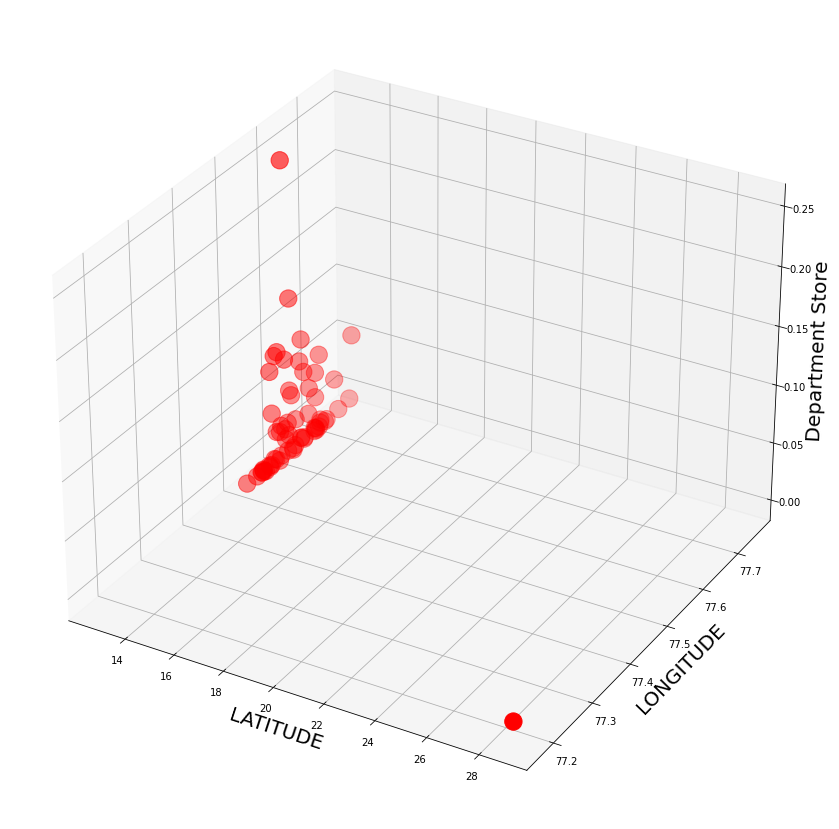

In [69]:
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")

ax.scatter3D( df_merged.Latitude, df_merged.Longitude,df_merged['Department Store'],s=300, color = 'red' )

ax.set_xlabel('LATITUDE', fontsize=20, rotation=150)
ax.set_ylabel('LONGITUDE',fontsize=20)
ax.set_zlabel('Department Store', fontsize=20, rotation=60)
plt.show()

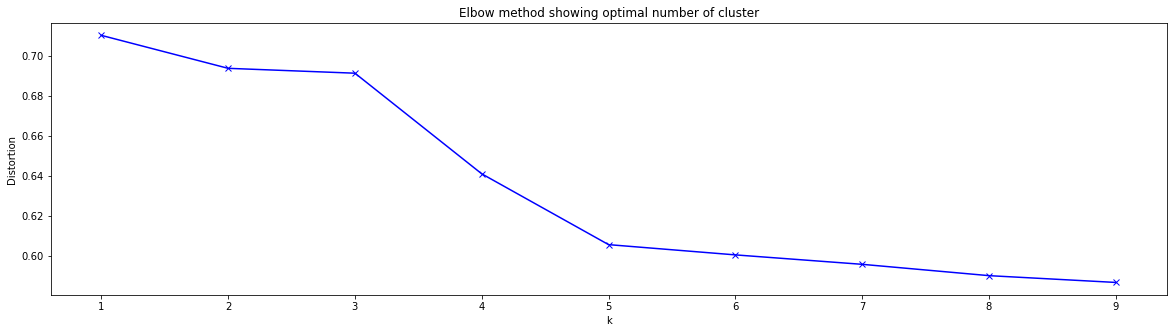

In [59]:
#the above graph shows how data is randomly distributes hence it is a unsupervised machine learning problem.
#we will use KMeans clustering but for that we need a perfect value of k

distortions=[]
K=range(1,10)
for k in K:
    kmeans=KMeans(n_clusters=k,random_state=0).fit(df_cluster)
    distortions.append(sum(np.min(cdist(df_cluster, kmeans.cluster_centers_, 'canberra'), axis=1)) / df_cluster.shape[0])
plt.plot(K,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow method showing optimal number of cluster")
plt.show()

In [60]:
#from the elbow method graph it is clear that k=5 will give most accuracy

k=5
df_cluster=df_store.drop(["Neighborhood"],1)
kmeans=KMeans(n_clusters=k,random_state=0).fit(df_cluster)
kmeans.labels_[0:10]

array([0, 3, 4, 4, 0, 0, 0, 0, 0, 0])

In [57]:
df_merged=df_store.copy()
df_merged["Cluster_Labels"]=kmeans.labels_
df_merged = df_merged.merge(df_neighborhood, on="Neighborhood", how="left")
df_merged = df_merged.merge(df_topvenues, on="Neighborhood", how="left")
df_merged.sort_values(['Cluster_Labels'],inplace=True)
print(df_merged.shape)
df_merged.head(10)

(63, 15)


,Neighborhood,Department Store,Cluster_Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,0.0,0,12.85811,77.55909,Pool,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store
29,Kengeri,0.0,0,12.90870,77.48714,Bus Station,Indian Restaurant,Café,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
61,Yelahanka,0.0,0,13.09931,77.59259,Café,American Restaurant,Clothing Store,Coffee Shop,Smoke Shop,Gym,Food Court,Fast Food Restaurant,Farmers Market,Multiplex
32,Krishnarajapuram,0.0,0,13.00039,77.68368,Women's Store,Bus Station,Intersection,Gym,Movie Theater,Playground,Coffee Shop,Ice Cream Shop,Train Station,Art Gallery
41,Nagarbhavi,0.0,0,12.95624,77.50936,Indian Restaurant,Café,South Indian Restaurant,Breakfast Spot,Andhra Restaurant,Market,Bakery,Falafel Restaurant,Food,Flea Market
42,Nandini Layout,0.0,0,13.01481,77.53891,Park,Indian Restaurant,Breakfast Spot,Food Truck,Vegetarian / Vegan Restaurant,Bus Line,Bakery,Event Space,Fish Market,Fish & Chips Shop
43,Nayandahalli,0.0,0,12.94205,77.52100,Coffee Shop,Clothing Store,Fried Chicken Joint,Auto Garage,Women's Store,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
44,Padmanabhanagar,0.0,0,12.91814,77.55940,Indian Restaurant,Fast Food Restaurant,Pizza Place,Snack Place,Shopping Mall,Pub,Movie Theater,South Indian Restaurant,Accessories Store,Bakery
45,Peenya,0.0,0,13.03188,77.52654,Indian Restaurant,Train Station,Light Rail Station,Fast Food Restaurant,Scenic Lookout,Bus Station,Coffee Shop,Arcade,Event Space,Food & Drink Shop
27,Kamakshipalya,0.0,0,12.98699,77.52484,Campground,Bus Station,Food,Indie Movie Theater,Department Store,Dessert Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


## 8. Visualizing the clusters on map

In [61]:
map_cluster = folium.Map(location=[lat,lon],zoom_start=10)

x=np.arange(k)
y=[i+x+(i*x)**2 for i in range(k)]
colors=cm.rainbow(np.linspace(0,1,len(y)))
rainbow = [color.rgb2hex(i) for i in colors]
markers=[]

for lt,lg,n,c in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster_Labels']):
    label = '{} - Cluster {}'.format(n,c)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lt,lg], radius=5, popup=label, color=rainbow[c-1], fill=True, fill_color=rainbow[c-1], fill_opacity=0.7).add_to(map_cluster)

map_cluster

## 9. Examining the cluster

### CLUSTER 0

In [62]:
df_merged.loc[df_merged['Cluster_Labels']==0] #red

,Neighborhood,Department Store,Cluster_Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,0.0,0,12.858110,77.559090,Pool,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store
29,Kengeri,0.0,0,12.908700,77.487140,Bus Station,Indian Restaurant,Café,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
61,Yelahanka,0.0,0,13.099310,77.592590,Café,American Restaurant,Clothing Store,Coffee Shop,Smoke Shop,Gym,Food Court,Fast Food Restaurant,Farmers Market,Multiplex
32,Krishnarajapuram,0.0,0,13.000390,77.683680,Women's Store,Bus Station,Intersection,Gym,Movie Theater,Playground,Coffee Shop,Ice Cream Shop,Train Station,Art Gallery
41,Nagarbhavi,0.0,0,12.956240,77.509360,Indian Restaurant,Café,South Indian Restaurant,Breakfast Spot,Andhra Restaurant,Market,Bakery,Falafel Restaurant,Food,Flea Market
42,Nandini Layout,0.0,0,13.014810,77.538910,Park,Indian Restaurant,Breakfast Spot,Food Truck,Vegetarian / Vegan Restaurant,Bus Line,Bakery,Event Space,Fish Market,Fish & Chips Shop
43,Nayandahalli,0.0,0,12.942050,77.521000,Coffee Shop,Clothing Store,Fried Chicken Joint,Auto Garage,Women's Store,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
44,Padmanabhanagar,0.0,0,12.918140,77.559400,Indian Restaurant,Fast Food Restaurant,Pizza Place,Snack Place,Shopping Mall,Pub,Movie Theater,South Indian Restaurant,Accessories Store,Bakery
45,Peenya,0.0,0,13.031880,77.526540,Indian Restaurant,Train Station,Light Rail Station,Fast Food Restaurant,Scenic Lookout,Bus Station,Coffee Shop,Arcade,Event Space,Food & Drink Shop
27,Kamakshipalya,0.0,0,12.986990,77.524840,Campground,Bus Station,Food,Indie Movie Theater,Department Store,Dessert Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


### CLUSTER 1

In [63]:
df_merged.loc[df_merged['Cluster_Labels']==1] #purple

,Neighborhood,Department Store,Cluster_Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Gottigere,0.25,1,12.85568,77.58557,Indian Restaurant,Department Store,Chinese Restaurant,Eastern European Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant


### CLUSTER 2

In [64]:
df_merged.loc[df_merged['Cluster_Labels']==2] #sea green

,Neighborhood,Department Store,Cluster_Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Mathikere,0.095238,2,13.03235,77.55866,Indian Restaurant,Department Store,Burger Joint,Gym,Juice Bar,Kerala Restaurant,Fast Food Restaurant,Diner,Park,Pizza Place
62,Yeshwanthpur,0.083333,2,13.02955,77.54022,Hotel,Indian Restaurant,Bar,Mediterranean Restaurant,Food Court,Seafood Restaurant,Scenic Lookout,Restaurant,Train Station,Wine Bar
30,Koramangala,0.086957,2,12.92004,77.62546,Indian Restaurant,Fast Food Restaurant,Department Store,Shop & Service,Indie Movie Theater,Furniture / Home Store,Park,Convenience Store,Restaurant,Café
19,Hebbal,0.133333,2,13.04981,77.58903,Indian Restaurant,Bus Station,Department Store,Bakery,Lake,Ice Cream Shop,Pizza Place,Pharmacy,Fast Food Restaurant,Building
51,Sadashivanagar,0.083333,2,13.01483,77.57771,Bus Station,Café,Plaza,Gym,Liquor Store,Performing Arts Venue,Department Store,Coffee Shop,Seafood Restaurant,Ice Cream Shop
33,Kumaraswamy Layout,0.090909,2,12.89819,77.55927,Café,Department Store,Chinese Restaurant,Fast Food Restaurant,Bakery,Sandwich Place,Restaurant,Breakfast Spot,Indie Movie Theater,Dive Bar


### CLUSTER 3

In [65]:
df_merged.loc[df_merged['Cluster_Labels']==3] #light green

,Neighborhood,Department Store,Cluster_Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arekere,0.050000,3,12.88568,77.59668,Indian Restaurant,Ice Cream Shop,Pizza Place,Sporting Goods Shop,Department Store,Fast Food Restaurant,Café,Bakery,Burger Joint,Fish Market
60,Whitefield,0.055556,3,12.97523,77.75238,Hotel,Eastern European Restaurant,Gym / Fitness Center,Indian Restaurant,Swiss Restaurant,Ice Cream Shop,Chinese Restaurant,Chaat Place,Café,Fast Food Restaurant
22,Hulimavu,0.044444,3,12.88064,77.60147,Sporting Goods Shop,Café,Indian Restaurant,Movie Theater,Supermarket,Bakery,Fast Food Restaurant,Electronics Store,Multiplex,Department Store
37,Mahalakshmi Layout,0.045455,3,13.01635,77.54481,Indian Restaurant,Park,Bus Station,Asian Restaurant,Fast Food Restaurant,Movie Theater,Miscellaneous Shop,Bus Line,Department Store,Market
36,Mahadevapura,0.062500,3,12.99409,77.66633,Indian Restaurant,Fast Food Restaurant,Café,Pizza Place,Department Store,Coffee Shop,Clothing Store,Italian Restaurant,Brewery,Shopping Mall
35,Madiwala,0.068966,3,12.92052,77.62090,Indian Restaurant,Fast Food Restaurant,Café,Department Store,Bus Stop,Furniture / Home Store,Halal Restaurant,Convenience Store,Restaurant,Coffee Shop
34,Lingarajapuram,0.058824,3,13.00548,77.62597,Café,Shopping Mall,Fast Food Restaurant,Indian Restaurant,Lounge,Coffee Shop,Park,Chinese Restaurant,New American Restaurant,Multiplex
18,HSR Layout,0.038462,3,12.91222,77.64470,Indian Restaurant,Café,Pizza Place,Snack Place,Chinese Restaurant,Ice Cream Shop,Department Store,Gym,Punjabi Restaurant,Chettinad Restaurant
25,Jeevanbheemanagar,0.048780,3,12.96601,77.65767,Indian Restaurant,Juice Bar,Park,Café,Fast Food Restaurant,Chinese Restaurant,Department Store,Dessert Shop,Gym,Karnataka Restaurant


### CLUSTER 4

In [66]:
df_merged.loc[df_merged['Cluster_Labels']==4] #orange

,Neighborhood,Department Store,Cluster_Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Malleswaram,0.027778,4,13.00632,77.568405,Indian Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Café,Breakfast Spot,South Indian Restaurant,Coffee Shop,Boat or Ferry,Chinese Restaurant,Bakery
23,J. P. Nagar,0.023529,4,12.90831,77.590240,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Café,Coffee Shop,Bakery,Diner,Brewery,Department Store,Pizza Place
24,Jayanagar,0.020000,4,12.92872,77.582810,Indian Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Coffee Shop,Lounge,Fast Food Restaurant,Juice Bar,Hotel,Jewelry Store
2,BTM Layout,0.020833,4,12.91495,77.610010,Indian Restaurant,Bakery,Vegetarian / Vegan Restaurant,Ice Cream Shop,Coffee Shop,Snack Place,Pizza Place,Chinese Restaurant,Café,Sandwich Place
57,Vasanth Nagar,0.013333,4,12.99073,77.588610,Indian Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Café,Pub,Italian Restaurant,Lounge,Nightclub,Pizza Place
28,Kammanahalli,0.018519,4,13.01430,77.636850,Indian Restaurant,Fast Food Restaurant,Café,Korean Restaurant,Restaurant,Bakery,BBQ Joint,Ice Cream Shop,Chinese Restaurant,Bistro
39,Marathahalli,0.028571,4,12.95466,77.707520,Indian Restaurant,Clothing Store,Sports Bar,Pizza Place,Chinese Restaurant,Hotel,Vegetarian / Vegan Restaurant,Bus Station,Furniture / Home Store,Ice Cream Shop
52,Seshadripuram,0.012346,4,12.99355,77.579880,Indian Restaurant,Hotel,Café,Coffee Shop,Clothing Store,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Restaurant,Ice Cream Shop,Karnataka Restaurant
48,Rajajinagar,0.025641,4,13.00544,77.556930,Indian Restaurant,Café,Italian Restaurant,Coffee Shop,Lounge,Bowling Alley,Vegetarian / Vegan Restaurant,Donut Shop,Multiplex,Ice Cream Shop
3,Banashankari,0.021277,4,12.92231,77.569880,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Café,Pizza Place,South Indian Restaurant,Snack Place,Italian Restaurant,Karnataka Restaurant,Food Court
